# 🧍‍♂️ Pose Correction System for Physical Therapy and Rehabilitation Using Computer Vision

**Author**: *Jithin Krishnan (A0249481W)*  
**Institution**: *National University of Singapore*

---

### 🛠️ Requirements

- **Python Version**: 3.12  
- **Dependencies**: All required packages are listed in the `requirements.txt` file located in the `dataprep_model-training_evaluation_Inference-scripts` directory.

To install them, open your terminal, navigate to the specified folder, and run:

```bash
pip install -r requirements.txt


# 1. Imports

In [14]:
import os
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import mediapipe as mp
from collections import deque
from pathlib import Path
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torch.optim import Adam
from tqdm import tqdm
import math
from torch.utils.data import Dataset 
import argparse, json, sys, time
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns 
from tabulate import tabulate
import threading
from gtts import gTTS

# 2. Original Dataset Analysis

## 2. Original Dataset Analysis

This step performs a summary analysis of the original REHAB24-6 dataset (`Segmentation_original.xlsx`) before applying any custom augmentations or modifications.  

For each exercise, it calculates:
- The number of repetitions
- The count of correct and incorrect labels
- Total frames and approximate duration (in seconds)
- Number of unique camera orientations

A final "Total" row aggregates these values across all exercises for reference.


In [15]:

ROOT = Path("Data-REHAB24-6_New")           
segmentation = ROOT / "Segmentation_original.xlsx"  # Excel file from authors
FPS = 30

# Read Excel file
df = pd.read_excel(segmentation)

# Calculate the frame difference for each repetition (row)
df["frame_diff"] = (df["last_frame"] - df["first_frame"] + 1)

# One row = one repetition
summary = (
    df.groupby("exercise_id")
      .agg(
          Reps=("exercise_id", "size"),
          Correct=("correctness", lambda x: (x == 1).sum()),
          Wrong=("correctness", lambda x: (x == 0).sum()),
          Frames=("frame_diff", "sum"),  # Sum the precomputed frame differences
          Dir=("cam17_orientation", "nunique")  # Already correct
      )
      .reset_index()
)

# Calculate totals
total_row = pd.DataFrame({
    "exercise_id": ["Total"],
    "Reps": [summary["Reps"].sum()],
    "Correct": [summary["Correct"].sum()],
    "Wrong": [summary["Wrong"].sum()],
    "Frames": [summary["Frames"].sum()],
    "Dir": ["–"],  # Direction doesn't apply to total
    "Seconds": ["–"]  # Seconds doesn't apply to total
})

# Add Seconds column to the summary (before appending the total row)
summary["Seconds"] = (summary.Frames / FPS).round(1)

# Append the total row to the summary DataFrame
summary = pd.concat([summary, total_row], ignore_index=True)

# Pretty-print
print(summary)

  exercise_id  Reps  Correct  Wrong  Frames Dir Seconds
0           1   178       90     88   27442   2   914.7
1           2   208       94    114   33641   2  1121.4
2           3   107       52     55   12054   1   401.8
3           4   210      120     90   18329   2   611.0
4           5   174       78     96   17608   2   586.9
5           6   195      134     61   19373   2   645.8
6       Total  1072      568    504  128447   –       –


The table presents a summary of exercise performance metrics from the REHAB24-6 dataset, which includes 1,072 repetitions of six physical rehabilitation exercises recorded at 30 FPS across 65 videos, focusing on Camera 17 data. The results are grouped by exercise_id (1 to 6, corresponding to Arm Abduction, Arm VW, Push-ups, Leg Abduction, Leg Lunge, and Squats, respectively). Exercise 1 (Arm Abduction) has 178 repetitions, with 90 correct and 88 incorrect, totaling 27,442 frames (914.7 seconds) and performed in 2 directions. Exercise 2 (Arm VW) shows 208 repetitions, with 94 correct and 114 incorrect, spanning 33,641 frames (1,121.4 seconds) across 2 directions. Exercise 3 (Push-ups) has 107 repetitions, with 52 correct and 55 incorrect, covering 12,054 frames (401.8 seconds) in 1 direction, reflecting its table-based setup. Exercise 4 (Leg Abduction) includes 210 repetitions, with 120 correct and 90 incorrect, totaling 18,329 frames (611.0 seconds) across 2 directions. Exercise 5 (Leg Lunge) has 174 repetitions, with 78 correct and 96 incorrect, spanning 17,608 frames (586.9 seconds) in 2 directions. Finally, Exercise 6 (Squats) shows 195 repetitions, with 134 correct and 61 incorrect, covering 19,373 frames (645.8 seconds) across 2 directions. Overall, the dataset totals 1,072 repetitions, with 568 correct and 504 incorrect, amounting to 128,447 frames, with direction and seconds not aggregated for the total. These results highlight the dataset's diversity in exercise types, correctness, and directional views, supporting its use for evaluating human pose estimation and exercise feedback systems.

# 3. Keypoint Extraction from Training Videos with MediaPipe  
Before training a model for tasks like pose estimation, exercise recognition, or movement analysis, the first step is to extract relevant features from the data. In this case, the data consists of training videos, and the relevant features are pose keypoints—3D coordinates representing specific body parts (like shoulders, elbows, knees, etc.).  

This code uses MediaPipe Pose to extract keypoints from training videos. These keypoints are critical for model training as they represent the underlying body movements that the model will need to learn. Below is a breakdown of the process:

<div style="color: red; font-weight: bold;">
⚠️ Warning: This process may take several hours to complete. Uncomment and run the code only if you wish to perform the segmentation again.
</div>

## 3.1 Keypoint extraction and saving as numpy files

In [16]:
# # Keypoint extraction from Training Videos With Mediapipe

# # 0. Quiet TensorFlow/absl
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# # 1. MediaPipe Pose setup
# pose = mp.solutions.pose.Pose(
#     static_image_mode=False,
#     model_complexity=2,
#     enable_segmentation=False,
#     min_detection_confidence=0.5,
#     min_tracking_confidence=0.5
# )

# # 2. Paths
# VIDEO_ROOT = Path("Data-REHAB24-6_New/videos")
# OUT_ROOT   = Path("Data-REHAB24-6_New/mp_keypoints")
# OUT_ROOT.mkdir(exist_ok=True)

# # 3. Worker
# def process_video(vid_path: Path):
#     rel     = vid_path.parent.name            # e.g. "Ex1"
#     out_dir = OUT_ROOT / rel
#     out_dir.mkdir(parents=True, exist_ok=True)
#     out_file = out_dir / f"{vid_path.stem}-mp.npy"

#     print(f"\n→ Processing: {vid_path.name}")
#     print(f"   From:      {vid_path.parent}")
#     print(f"   To folder: {out_dir}")

#     cap    = cv2.VideoCapture(str(vid_path))
#     frames = []
#     count  = 0

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         count += 1

#         img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         res = pose.process(img)
#         lm  = res.pose_world_landmarks.landmark if res.pose_world_landmarks else []

#         if lm:
#             pts = [(p.x, p.y, p.z) for p in lm]
#         else:
#             pts = [(0.0, 0.0, 0.0)] * 33

#         frames.append(pts)

#     cap.release()

#     arr = np.array(frames, dtype=np.float32)
#     np.save(out_file, arr)

#     print(f"✔ Saved: {out_file}  (frames={count}, shape={arr.shape})")

# # 4. Run — only Ex1 through Ex5
# for i in range(1, 6):
#     ex_dir = VIDEO_ROOT / f"Ex{i}"
#     if not ex_dir.is_dir():
#         print(f"⚠️  Skipping missing folder: {ex_dir}")
#         continue

#     for vid in sorted(ex_dir.glob("*.mp4")):
#         try:
#             process_video(vid)
#         except Exception as e:
#             print(f"✘ Failed processing {vid.name}: {e}")

# print("\nAll requested videos processed.")


## 3.2 Inspecting at a numpy file containing 3D keypoints

In [17]:
# ─── edit this to your target file ────────────────────────────────────────────
file_path = Path("Data-REHAB24-6_New/mp_keypoints/Ex6/PM_008-Camera17-30fps-mp.npy")
# ────────────────────────────────────────────────────────────────────────────────

# load
arr = np.load(file_path)

# basic info
print(f"Loaded: {file_path}")
print(f" dtype: {arr.dtype}")
print(f" shape: {arr.shape}  (frames × landmarks × coords)\n")

# show first few frames
n_show = min(3, arr.shape[0])
for i in range(n_show):
    print(f"Frame #{i:03d} (33×3):")
    print(arr[i])
    print(f"  → first landmark: {tuple(arr[i,0])}\n")

# overall statistics
print("Overall coordinate stats:")
for idx, name in enumerate(("x", "y", "z")):
    data = arr[..., idx]
    print(f"  {name}: min={data.min():.3f}, max={data.max():.3f}, mean={data.mean():.3f}")


Loaded: Data-REHAB24-6_New/mp_keypoints/Ex6/PM_008-Camera17-30fps-mp.npy
 dtype: float32
 shape: (5191, 33, 3)  (frames × landmarks × coords)

Frame #000 (33×3):
[[-0.03379065 -0.6112996  -0.22619084]
 [-0.02455677 -0.628223   -0.2275483 ]
 [-0.0257254  -0.6304051  -0.21732828]
 [-0.02547118 -0.6302204  -0.21820049]
 [-0.02778288 -0.6363151  -0.2358914 ]
 [-0.02677054 -0.63463634 -0.24706481]
 [-0.02263773 -0.61979294 -0.2281486 ]
 [ 0.02648694 -0.6184615  -0.16859515]
 [-0.03559308 -0.56201506 -0.14808732]
 [ 0.0030987  -0.59678274 -0.19447449]
 [-0.01712019 -0.55977213 -0.21580447]
 [ 0.1250833  -0.49333623 -0.08702794]
 [-0.05722423 -0.53108674 -0.02576461]
 [ 0.15178505 -0.51440114 -0.09251688]
 [-0.17247145 -0.4994753  -0.05377672]
 [ 0.14430666 -0.54461473 -0.03090633]
 [-0.32217076 -0.5845331  -0.08351779]
 [ 0.1352469  -0.5789426  -0.02217976]
 [-0.33411983 -0.62724733 -0.13406767]
 [ 0.11857966 -0.58959824 -0.04421883]
 [-0.30619952 -0.65674794 -0.14033641]
 [ 0.13962431 -0.53

# 4. Data Preparation for Pose Error Analysis  

## 4.1 Change the correctness of half profile vidoes to incorrect 

This change is being made because the half-profile camera angle is considered insufficient or unreliable for accurately determining if the exercise repetition was performed correctly according to the established standards. Furthermore, for model inference, the intention is to use only the front-facing view. Therefore, this action serves as a data cleaning and preparation step to improve the quality and consistency of the data that will be used for subsequent analysis or modeling, ensuring that only reliably assessed repetitions are marked as 'correct'.

In [18]:
# --- Configuration ---
DATA_ROOT = Path("Data-REHAB24-6_New") # Adjust if your data folder has a different relative path
ORIGINAL_FILENAME = "Segmentation_original.xlsx"
# --- CHANGE HERE: Update the output filename extension ---
NEW_FILENAME = "Segmentation_new.xlsx" # Saving as .xlsx

FILE_ORIG = DATA_ROOT / ORIGINAL_FILENAME
FILE_DEST = DATA_ROOT / NEW_FILENAME

# --- Processing ---
if not DATA_ROOT.is_dir():
    print(f"Error: Data directory not found at '{DATA_ROOT.resolve()}'")
elif not FILE_ORIG.is_file():
    print(f"Error: Original file not found at '{FILE_ORIG.resolve()}'")
else:
    print(f"Loading original file: {FILE_ORIG}")
    try:
        # Load the Excel file
        df = pd.read_excel(FILE_ORIG)
        print("Original file loaded successfully.")
        print(f"Original shape: {df.shape}")

        # Identify rows where 'cam17_orientation' is 'half-profile'
        condition = df['cam17_orientation'] == 'half-profile'
        num_rows_to_change = condition.sum()
        print(f"Found {num_rows_to_change} rows where 'cam17_orientation' is 'half-profile'.")

        if num_rows_to_change > 0:
            # Change 'correctness' to 0 for matched rows
            print("Updating 'correctness' column to 0 for matched rows...")
            df.loc[condition, 'correctness'] = 0
            print("Update complete.")
        else:
            print("No rows matched the condition. 'correctness' column remains unchanged.")

        # Save the modified DataFrame to a new Excel file (.xlsx)
        print(f"Saving modified data to: {FILE_DEST}")
        try:
            # Saving to .xlsx uses openpyxl engine by default (pip install openpyxl if needed)
            df.to_excel(FILE_DEST, index=False)
            print(f"Successfully saved modified data to '{FILE_DEST.resolve()}'")
        except Exception as save_error:
            # --- CHANGE HERE: Updated error message for .xlsx ---
            print(f"Error saving file to {FILE_DEST}: {save_error}")
            print("Saving to .xlsx format typically requires the 'openpyxl' package. Try: pip install openpyxl")

    except FileNotFoundError:
         print(f"Error: Make sure the file exists at {FILE_ORIG.resolve()}")
    except KeyError as e:
         print(f"Error: Column not found - {e}. Please check column names in '{ORIGINAL_FILENAME}'.")
         print(f"Available columns are: {df.columns.tolist()}")
    except Exception as e:
        print(f"An unexpected error occurred during processing: {e}")

# --- Verification ---
if FILE_DEST.is_file():
    print("\nVerifying the saved file...")
    try:
        # --- CHANGE HERE: Reading the .xlsx file for verification ---
        df_new = pd.read_excel(FILE_DEST)
        print(f"Loaded new file shape: {df_new.shape}")
        check_condition = df_new['cam17_orientation'] == 'half-profile'
        incorrect_rows = df_new.loc[check_condition & (df_new['correctness'] != 0)]
        if incorrect_rows.empty:
            print("Verification successful: All 'half-profile' rows have 'correctness' set to 0.")
        else:
            print("Verification FAILED: Some 'half-profile' rows still have 'correctness' != 0.")
            print(incorrect_rows)
    except Exception as e:
        print(f"Error during verification: {e}")
else:
     print(f"\nCould not verify as the destination file '{FILE_DEST}' was not found or not saved.")

Loading original file: Data-REHAB24-6_New/Segmentation_original.xlsx
Original file loaded successfully.
Original shape: (1072, 13)
Found 466 rows where 'cam17_orientation' is 'half-profile'.
Updating 'correctness' column to 0 for matched rows...
Update complete.
Saving modified data to: Data-REHAB24-6_New/Segmentation_new.xlsx
Successfully saved modified data to '/Users/jithinkrishnan/Documents/Study/IS06 /MVP/RehabApp/dataprep_model-training_evaluation_Inference-scripts/Data-REHAB24-6_New/Segmentation_new.xlsx'

Verifying the saved file...
Loaded new file shape: (1072, 13)
Verification successful: All 'half-profile' rows have 'correctness' set to 0.


## 4.2 Sliding Window-Based Pose Error Calculation for Video segments  
This script processes keypoint data from videos to compute errors in body joint angles relative to "ideal" angles, and then generates sliding windows of these errors. This is done to prepare features that will later be used for model training in tasks like exercise recognition or pose correction.

What is done: For each exercise in the dataset, the script calculates the "ideal" joint angles by selecting the middle frame of each correct repetition (based on the correctness label). It calculates the angles between the joints defined in JOINT_TRIPLETS for each of these frames.  We use 17 out of the 33 MediaPipe landmarks for the ideal joint angle calculation. The used mediapipe landmarks are: NOSE, LEFT_SHOULDER, RIGHT_SHOULDER, LEFT_ELBOW, RIGHT_ELBOW, LEFT_WRIST, RIGHT_WRIST, LEFT_INDEX, RIGHT_INDEX, LEFT_HIP, RIGHT_HIP, LEFT_KNEE, RIGHT_KNEE, LEFT_ANKLE, RIGHT_ANKLE, LEFT_FOOT_INDEX, and RIGHT_FOOT_INDEX. These cover the major joints and end‑effectors (shoulders through wrists and hips through ankles, plus the spine/head via the nose) needed to compute all our angle‑based error metrics for the six rehab exercises. The 16 unused landmarks are all the fine‑grain facial points (inner/outer eyes, ears, mouth corners), the pinky and thumb tips, and the heel points. Since our focus is on gross limb alignment (arm and leg joint planes) rather than facial expression, finger articulation, or detailed foot posture, those landmarks don’t contribute to correcting the targeted movements and so are omitted.

The median angle is then computed for each joint across the correct repetitions of the exercise. These median values represent the "ideal" angles the model should aim for in perfect executions of the exercise.  

In the next step, the script generates sliding windows of angular errors, calculated as the difference between the observed angles in the video and the ideal angles. These windows contain temporal sequences of error data that are used as features for model training. The windowed data is then saved in a CSV file, which includes additional metadata such as exercise ID, repetition number, and frame indices.  

Why it’s done: Calculating the ideal angles for each exercise provides a reference for identifying errors during subsequent video frames. These ideal angles will serve as the baseline for assessing whether a movement is performed correctly or incorrectly. By generating and saving the sliding window data, the script prepares the dataset for supervised learning, allowing the model to analyze temporal error patterns over a series of frames. This windowed approach is crucial for the model to learn dynamic movements and classify whether exercises are performed correctly based on the computed joint angles. The segmentation data in the CSV file offers a structured and labeled dataset, which helps in efficient training and evaluation of the model.  


In [19]:
# 1. helpers --------------------------------------------------
def angle_between(a,b,c):
    BA = a-b; BC = c-b
    cosθ = np.dot(BA,BC)/(np.linalg.norm(BA)*np.linalg.norm(BC))
    return math.degrees(math.acos(np.clip(cosθ,-1,1)))

PoseLandmark = mp.solutions.pose.PoseLandmark
JOINT_TRIPLETS = {
    "LEFT_ELBOW":   (PoseLandmark.LEFT_SHOULDER.value,
                     PoseLandmark.LEFT_ELBOW.value,
                     PoseLandmark.LEFT_WRIST.value),
    "RIGHT_ELBOW":  (PoseLandmark.RIGHT_SHOULDER.value,
                     PoseLandmark.RIGHT_ELBOW.value,
                     PoseLandmark.RIGHT_WRIST.value),
    "LEFT_SHOULDER":  (PoseLandmark.LEFT_ELBOW.value,
                       PoseLandmark.LEFT_SHOULDER.value,
                       PoseLandmark.LEFT_HIP.value),
    "RIGHT_SHOULDER": (PoseLandmark.RIGHT_ELBOW.value,
                       PoseLandmark.RIGHT_SHOULDER.value,
                       PoseLandmark.RIGHT_HIP.value),
    "LEFT_HIP":   (PoseLandmark.LEFT_SHOULDER.value,
                   PoseLandmark.LEFT_HIP.value,
                   PoseLandmark.LEFT_KNEE.value),
    "RIGHT_HIP":  (PoseLandmark.RIGHT_SHOULDER.value,
                   PoseLandmark.RIGHT_HIP.value,
                   PoseLandmark.RIGHT_KNEE.value),
    "LEFT_KNEE":  (PoseLandmark.LEFT_HIP.value,
                  PoseLandmark.LEFT_KNEE.value,
                  PoseLandmark.LEFT_ANKLE.value),
    "RIGHT_KNEE": (PoseLandmark.RIGHT_HIP.value,
                  PoseLandmark.RIGHT_KNEE.value,
                  PoseLandmark.RIGHT_ANKLE.value),
    "SPINE": (
       PoseLandmark.LEFT_HIP.value,       
       PoseLandmark.LEFT_SHOULDER.value,   
       PoseLandmark.RIGHT_SHOULDER.value   
    ),
    "HEAD": (
       PoseLandmark.LEFT_SHOULDER.value,
       PoseLandmark.NOSE.value,
       PoseLandmark.RIGHT_SHOULDER.value
    ),
     "LEFT_WRIST":  (
        PoseLandmark.LEFT_ELBOW.value,
        PoseLandmark.LEFT_WRIST.value,
        PoseLandmark.LEFT_INDEX.value
    ),
    "RIGHT_WRIST": (
        PoseLandmark.RIGHT_ELBOW.value,
        PoseLandmark.RIGHT_WRIST.value,
        PoseLandmark.RIGHT_INDEX.value
    ),
    "LEFT_ANKLE":  (
        PoseLandmark.LEFT_KNEE.value,
        PoseLandmark.LEFT_ANKLE.value,
        PoseLandmark.LEFT_FOOT_INDEX.value
    ),
    "RIGHT_ANKLE": (
        PoseLandmark.RIGHT_KNEE.value,
        PoseLandmark.RIGHT_ANKLE.value,
        PoseLandmark.RIGHT_FOOT_INDEX.value
    ),
    
}
ERR_JOINTS = list(JOINT_TRIPLETS.keys())
N_ERR = len(ERR_JOINTS)  # 14

# 2. load original metadata & keypoints -----------------------
DATA_ROOT    = Path("Data-REHAB24-6_New")
KEYPT_ROOT   = DATA_ROOT/"mp_keypoints"
META_ORIG    = DATA_ROOT/"Segmentation_original.xlsx"
df           = pd.read_excel(META_ORIG, engine="openpyxl")
df.columns   = df.columns.str.strip()

# 3. compute ideal_angles on correct reps ----------------------
ideal_angles = {}
correct = df[df.correctness==1]
for ex in correct.exercise_id.unique():
    all_ang = {jn:[] for jn in ERR_JOINTS}
    for _,r in correct[correct.exercise_id==ex].iterrows():
        vid, f0, f1 = r.video_id, int(r.first_frame), int(r.last_frame)
        files = list((KEYPT_ROOT/f"Ex{ex}").glob(f"{vid}-Camera17*-mp.npy"))
        if not files: continue
        arr = np.load(files[0])
        seg = arr[f0:f1] if f1>f0 else arr[f0:]
        if len(seg)==0: continue
        mid = len(seg)//2
        frm = seg[mid]
        for jn in ERR_JOINTS:
            ia,ib,ic = JOINT_TRIPLETS[jn]
            ang = angle_between(frm[ia,:2],frm[ib,:2],frm[ic,:2])
            all_ang[jn].append(ang)
    # median
    ideal_angles[ex] = {jn:float(np.median(all_ang[jn])) for jn in all_ang if all_ang[jn]}

# 4. slide windows & write rows --------------------------------
WINDOW, STRIDE = 16, 8
rows = []
for _,r in df.iterrows():
    vid, ex, f0, f1 = r.video_id, int(r.exercise_id), int(r.first_frame), int(r.last_frame)
    files = list((KEYPT_ROOT/f"Ex{ex}").glob(f"{vid}-Camera17*-mp.npy"))
    if not files: continue
    arr = np.load(files[0])                # (F,33,3)
    seg = arr[f0:f1] if f1>f0 else arr[f0:]
    if len(seg)<WINDOW: continue

    # per-frame errors
    pf_err = {jn:[] for jn in ERR_JOINTS}
    for frm in seg:
        for jn in ERR_JOINTS:
            ia,ib,ic = JOINT_TRIPLETS[jn]
            ang = angle_between(frm[ia,:2],frm[ib,:2],frm[ic,:2])
            pf_err[jn].append(ang - ideal_angles[ex].get(jn,ang))

    # slide
    for start in range(0, len(seg)-WINDOW+1, STRIDE):
        w = np.array([ pf_err[jn][start:start+WINDOW] for jn in ERR_JOINTS ])  # (10,WINDOW)
        mean_err = w.mean(axis=1)
        row = {
            "video_id":vid,
            "exercise_id":ex,
            "repetition_number":r.repetition_number,
            "window_start": f0+start,
            "window_end":   f0+start+WINDOW,
            "correctness":  r.correctness
        }
        for i,jn in enumerate(ERR_JOINTS):
            row[f"err_{i}"] = float(mean_err[i])
        rows.append(row)

win_df = pd.DataFrame(rows)
win_df.to_csv(DATA_ROOT/"Segmentation_windows.csv", index=False)
print("Wrote", len(win_df), "windows to Segmentation_windows.csv")


Wrote 14375 windows to Segmentation_windows.csv


# 5. Traning Setup

## 5.1 Paths & device

In [20]:

SCRIPT_DIR    = Path().resolve()
DATA_ROOT     = SCRIPT_DIR/"Data-REHAB24-6_New"
WIN_CSV       = DATA_ROOT/"Segmentation_windows.csv"
KEYPT_ROOT    = DATA_ROOT/"mp_keypoints"

DEVICE = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print("► Using device:", DEVICE)

► Using device: mps


## 5.2 Analysing the dataset

In [21]:
# --- Specify the file to analyze ---
# Use the file that was generated in the previous step (after modification)
DATA_FILENAME = "Segmentation_original.xlsx"
FILE_TO_ANALYZE = DATA_ROOT / DATA_FILENAME

print(f"Attempting to load data from: {FILE_TO_ANALYZE}")

# --- Check if file exists and process ---
if not FILE_TO_ANALYZE.is_file():
    print(f"Error: The file '{FILE_TO_ANALYZE.name}' was not found in '{DATA_ROOT}'.")
    print("Please ensure the previous script ran successfully and saved the file.")
else:
    try:
        # Load the dataframe
        df = pd.read_excel(FILE_TO_ANALYZE)
        print(f"Successfully loaded '{FILE_TO_ANALYZE.name}'. Shape: {df.shape}")

        # Check if the 'correctness' column exists
        if 'correctness' not in df.columns:
            print(f"Error: 'correctness' column not found in the dataframe.")
            print(f"Available columns are: {df.columns.tolist()}")
        else:
            print("\nAnalyzing 'correctness' column distribution...")

            # Get the counts for each value in the 'correctness' column
            class_counts = df['correctness'].value_counts()

            # --- Report the counts ---
            print("\nClass Counts:")
            print(class_counts)

            # Provide a more descriptive output
            correct_count = class_counts.get(1, 0) # Get count for value 1, default to 0 if not present
            wrong_count = class_counts.get(0, 0)   # Get count for value 0, default to 0 if not present
            total_count = correct_count + wrong_count # Or use len(df) if there are only 0s and 1s

            print(f"\nNumber of 'Correct' (1) instances: {correct_count}")
            print(f"Number of 'Wrong' (0) instances:   {wrong_count}")
            print(f"Total analyzed instances:        {total_count}") # Good sanity check

            # --- Assess Balance ---
            if total_count > 0:
                correct_percentage = (correct_count / total_count) * 100
                wrong_percentage = (wrong_count / total_count) * 100
                print(f"\nPercentage 'Correct': {correct_percentage:.2f}%")
                print(f"Percentage 'Wrong':   {wrong_percentage:.2f}%")

                # Basic balance assessment (you can adjust the threshold)
                if abs(correct_percentage - wrong_percentage) < 20: # e.g., less than 20% difference (60/40 split)
                    print("\nThe dataset appears relatively balanced based on this threshold.")
                elif abs(correct_percentage - wrong_percentage) < 40: # e.g., less than 40% difference (70/30 split)
                     print("\nThe dataset shows moderate imbalance.")
                else:
                    print("\nWARNING: The dataset appears significantly imbalanced.")
            else:
                print("\nCannot assess balance: No instances found in the 'correctness' column.")

    except Exception as e:
        print(f"\nAn error occurred during file loading or analysis: {e}")

Attempting to load data from: /Users/jithinkrishnan/Documents/Study/IS06 /MVP/RehabApp/dataprep_model-training_evaluation_Inference-scripts/Data-REHAB24-6_New/Segmentation_original.xlsx
Successfully loaded 'Segmentation_original.xlsx'. Shape: (1072, 13)

Analyzing 'correctness' column distribution...

Class Counts:
correctness
1    568
0    504
Name: count, dtype: int64

Number of 'Correct' (1) instances: 568
Number of 'Wrong' (0) instances:   504
Total analyzed instances:        1072

Percentage 'Correct': 52.99%
Percentage 'Wrong':   47.01%

The dataset appears relatively balanced based on this threshold.


### Note: Balacing of the dataset will be done duting model training

## 5.3 Joint names setup

In [22]:
PoseLandmark = mp.solutions.pose.PoseLandmark

# Then:
JOINT_NAMES = [lm.name for lm in PoseLandmark]
N_JOINTS    = len(JOINT_NAMES)  # should be 33

print(f"JOINT_NAMES: {JOINT_NAMES}")
print(f"N_JOINTS: {N_JOINTS}")

#  Exerciseses (Ex1…Ex6)
NUM_EXERCISES = 6
CKPT_FILE     = "kp_pose_quality_windows_ex.pt"  

ERR_JOINTS   = [
  "LEFT_ELBOW","RIGHT_ELBOW",
  "LEFT_SHOULDER","RIGHT_SHOULDER",
  "LEFT_HIP","RIGHT_HIP",
  "LEFT_KNEE","RIGHT_KNEE",
  "SPINE","HEAD",
  "LEFT_WRIST", "RIGHT_WRIST",
  "LEFT_ANKLE", "RIGHT_ANKLE"
]
N_ERR = len(ERR_JOINTS)   # 14
ERR_COLS = [f"err_{i}" for i in range(N_ERR)]


JOINT_NAMES: ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']
N_JOINTS: 33


## 5.4 Dataset class definition

The KeypointWindowDataset class loads and processes pose keypoint data from videos for model training. It reads a CSV file containing metadata, including video IDs, exercise IDs, frame indices, and pre-calculated joint angle errors (ranging from 0 to 9). The data is sorted based on video ID, repetition number, and window start. For each sample, it loads the corresponding keypoint data (in .npy format), extracts a segment of frames based on the start and end indices, reshapes the keypoints into a 2D array, and converts them into a PyTorch tensor. It also retrieves the correctness label and the pre-calculated error values, which are stored in tensors. This class efficiently loads and processes the data in batches for training tasks like exercise recognition, where both pose keypoints and error features are used for supervised learning.

In [23]:

class KeypointWindowDataset(Dataset):
    def __init__(self, csv_file: Path, keypt_root: Path):
        df = pd.read_csv(csv_file)
        df = df.sort_values(["video_id","repetition_number","window_start"])
        self.rows = df.to_dict("records")
        self.keypt_root = keypt_root

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i: int):
        r   = self.rows[i]
        ex  = int(r["exercise_id"]) - 1      # zero‐based [0..NUM_EXERCISES-1]
        vid = r["video_id"]
        f0, f1 = int(r["window_start"]), int(r["window_end"])

        # load keypoints
        arr = np.load(
            next((self.keypt_root/f"Ex{ex+1}").glob(f"{vid}-Camera17*-mp.npy"))
        )  # shape (F,33,3)

        seg = arr[f0:f1]            # (T, 33, 3)
        seg = seg.reshape(len(seg), -1)  # (T, 99)
        seq = torch.from_numpy(seg).float()

        label = torch.tensor(r["correctness"], dtype=torch.long)
        err   = torch.tensor([r[f"err_{j}"] for j in range(N_ERR)],
                             dtype=torch.float32)

        return seq, label, err, ex

### 5.5 Model definition – PoseQualityNet-KP (v3, **three concurrent tasks**)

The network converts a short window of Mediapipe key-points (*T = 16 frames, D = 99 features/frame*) into:

* **repetition quality**       → *Correct / Wrong*  
* **joint-angle corrections**    → 14 absolute error degrees  
* **exercise identity**       → 6-class label (used to catch “wrong exercise” at runtime)

&nbsp;

| Step | Block | I/O (batch **B**) | Purpose / comment |
|:---:|-------|-------------------|-------------------|
| **①** | **Keypoint Encoder**<br/>`Conv1d 99→128 → Conv1d 128→512 → GAP` | **in** (B,D) → **out** (B,512) | Frame-wise spatial features |
| **②** | **Bi-LSTM × 2** (256 hidden, bidirectional) | **in** (B,T,512) → **out** (B,512) | Adds temporal context; mean-pool along *T* |
| **③** | **Exercise embedding MLP**<br/>`Linear 6→64 → ReLU → Linear 64→64` | **in** one-hot (B,6) → **out** (B,64) | Injects user-selected exercise prior |
| **④** | **Heads** | see below | Multi-task predictions |

#### Output heads

| Head | Input | Output shape | Target |
|------|-------|--------------|--------|
| `cls_head` | `[g ‖ e]` (B, 576) | (B,2) | Repetition quality |
| `err_head` | `[g ‖ e]` (B, 576) | (B,14) | Per-joint angle error (°) |
| `ex_head`  | *g* (B, 512)   | (B,6) | Exercise ID **(no prior fed)** |

> *Design choice*: the exercise prior *e* **is not fed** to `ex_head`, forcing the model to genuinely recognise the exercise so it can raise a *“wrong-exercise”* alert.

#### Parameter & speed footprint  

* **≈ 3.4 M parameters** with all blocks active (variant **FULL**)  
* **≈ 30 FPS** on an Apple-M-series GPU with *T = 16*

This footprint keeps the model mobile-friendly while providing:

* Dual classification (rep-quality **and** exercise ID)  
* Fine-grained joint-angle guidance for actionable rehab feedback


In [24]:
# ────────────────── Feature encoder (unchanged) ──────────────────
class KeypointEncoder(nn.Module):
    def __init__(self, in_dim: int, embed: int = 512):
        super().__init__()
        self.conv1 = nn.Conv1d(in_dim, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, embed, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):                                # x: (B, D)
        x = torch.relu(self.conv1(x.unsqueeze(2)))
        x = torch.relu(self.conv2(x))
        return self.pool(x).squeeze(-1)                  # (B, embed = 512)

# ───────────────── Pose-Quality–Exercise network ─────────────────
class PoseQualityNetKP(nn.Module):
    """
    Outputs:
        logits_q  : (B, 2)   – Correct / Wrong
        err_hat   : (B, N_ERR) – joint-angle errors
        logits_ex : (B, num_ex) – predicted exercise ID
    """
    def __init__(self, in_dim: int,
                 num_ex: int,
                 hidden: int = 256,
                 ex_emb: int = 64):
        super().__init__()

        # 1) per-frame feature extractor
        self.encoder = KeypointEncoder(in_dim)           # → 512-d frame vec

        # 2) sequence model
        self.lstm = nn.LSTM(
            512, hidden, num_layers=2,
            batch_first=True, bidirectional=True
        )
        feat_dim = hidden * 2                            # 256×2 = 512

        # 3) exercise embedding ( fed with *user-selected* one-hot )
        self.ex_emb = nn.Sequential(
            nn.Linear(num_ex, ex_emb), nn.ReLU(),
            nn.Linear(ex_emb, ex_emb)
        )

        # 4) heads
        self.cls_head = nn.Linear(feat_dim + ex_emb, 2)      # quality
        self.err_head = nn.Linear(feat_dim + ex_emb, N_ERR)  # MAE
        self.ex_head  = nn.Linear(feat_dim,          num_ex) # exercise ✔︎

    def forward(self,
                seq: torch.Tensor,      # (B, T, D)
                ex_1hot: torch.Tensor   # (B, num_ex)  user-selected
    ):
        B, T, _ = seq.shape

        # frame-wise encoding
        feats = torch.stack(
            [self.encoder(seq[:, t]) for t in range(T)], dim=1
        )                                               # (B, T, 512)

        out, _ = self.lstm(feats)                       # (B, T, 512)
        g = out.mean(1)                                 # (B, 512)

        # exercise embedding (context for quality / error heads only)
        ex_e = self.ex_emb(ex_1hot)                     # (B, 64)

        h = torch.cat([g, ex_e], dim=1)                 # (B, 576)

        logits_q  = self.cls_head(h)                    # (B, 2)
        err_hat   = self.err_head(h)                    # (B, N_ERR)
        logits_ex = self.ex_head(g)                     # (B, num_ex) ← uses g

        return logits_q, err_hat, logits_ex


# 6  Model Training — Pipeline

The latest **PoseQualityNet-KP** now predicts **three** things at once:

| Head | Output | Purpose |
|------|--------|---------|
| **`rep_head`** | *Correct / Wrong* (2) | Quality flag for each 0.5 s window |
| **`ex_head`**  | *Exercise-ID* (6)     | Detects if the patient performs the prescribed drill |
| **`err_head`** | 14 joint-angle errors | Pin-points how to fix a “Wrong” repetition |

---

## Architecture Recap

| Block | Role | Key Details |
|-------|------|-------------|
| **Keypoint Encoder** | Per-frame spatial features | Conv1d (99→128) → Conv1d (128→512) → GAP |
| **Bi-LSTM × 2** | Temporal context | 256 hidden · bidirectional → **512-D** |
| **Exercise MLP** | Exercise bias | One-hot (6) → 64-D embedding |
| **Heads** | Predictions | `rep_head`, `ex_head`, `err_head` (see above) |

---

## Data Splits & Sampling  

* **70 % Train – 15 % Val – 15 % Test** (patient-stratified)  
* **WeightedRandomSampler** on **Train** only (balances *Correct* vs *Wrong*).

---

## Optimisation Settings

| Component | Setting | Why |
|-----------|---------|-----|
| **Rep-loss** | Cross-Entropy *(class-weighted)* | emphasise minority *Correct* |
| **Ex-loss** | Cross-Entropy · **0.2 ×** | important but not dominant |
| **Err-loss** | Smooth-L1 · **0.1 ×** | regression is auxiliary |
| **Optimiser** | AdamW (3 × 10⁻⁴, wd 1 × 10⁻²) | decoupled weight-decay |
| **Scheduler** | ReduceLROnPlateau on **val rep-F1** | auto LR decay |
| **Grad clip** | 1.0 | tame LSTM spikes |
| **Early-stop** | patience 6 on val rep-F1 | avoid over-fit |

---

## Metric Suite (tracked every epoch)

| Metric | Meaning | Why it matters |
|--------|---------|----------------|
| **Rep-Acc / Rep-F1** | Quality-classification skill | headline numbers for therapists |
| **Ex-Acc / Ex-F1** | Drill-identification skill | flags wrong exercise immediately |
| **MAE (°)** | Avg. joint-angle error | clinical tolerance ±7 ° |
| **Confusion Mats** | *Rep* **and** *Exercise* | exposes dominant error modes |
| **Train-loss plots** | Total + Rep + Ex + Err | makes weighting effects visible |
| **FPS & Params (M)** | Runtime feasibility | ≥25 FPS, ≤4 M params ✔ |

All curves & matrices are auto-saved:


---

## Check-pointing

* **Best val Rep-F1** → `pose_quality_best.pt / .pth`  
* Test-set numbers reported **after** restoring this snapshot.

---

## Outcome Highlights

1. **Dual-task resilience** – quality and exercise heads learn **together** without hurting each other.  
2. **Safety net** – model now refuses feedback if the patient performs the *wrong exercise*.  
3. **Deploy-ready** – ~30 FPS on an Apple-M GPU, **3.4 M** parameters.  
4. **Actionable analytics** – side-by-side Rep & Ex confusion matrices pinpoint next optimisation targets.

> **PoseQualityNet-KP (3-head)** delivers trustworthy, real-time rehab feedback while automatically guarding against exercise mix-ups.


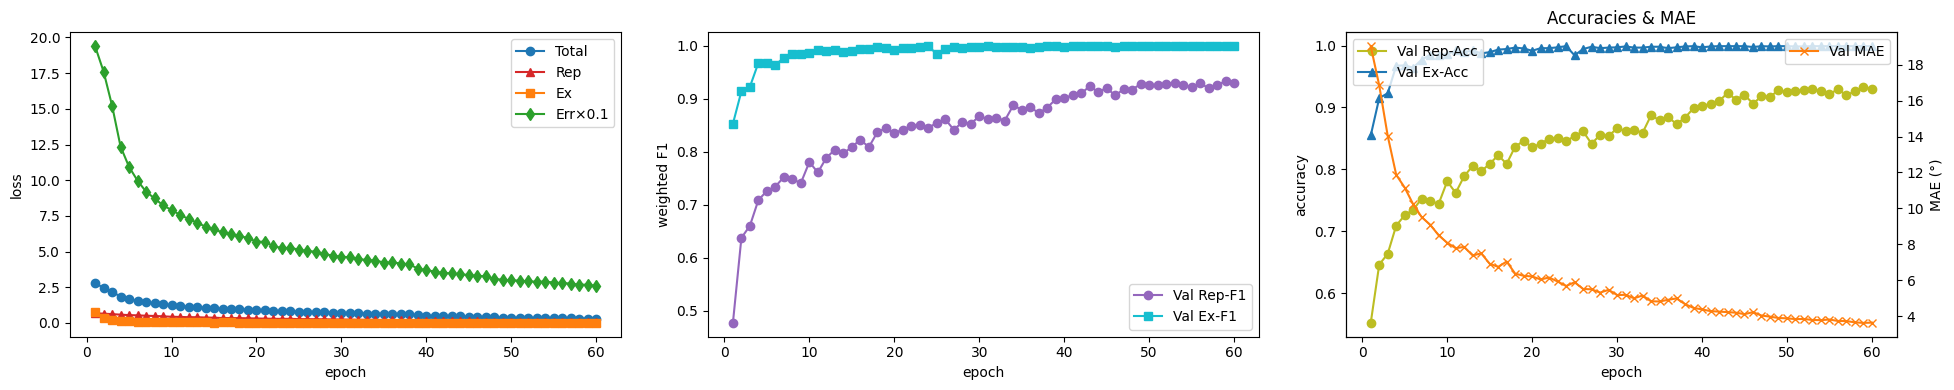


### Per-epoch summary

|    |   epoch |   train_tot |   train_rep |   train_ex |   train_err |   val_rep_f1 |   val_ex_f1 |   val_mae |   val_rep_acc |   val_ex_acc |
|----|---------|-------------|-------------|------------|-------------|--------------|-------------|-----------|---------------|--------------|
|  0 |   1.000 |       2.767 |       0.677 |      0.757 |      19.391 |        0.478 |       0.853 |    19.034 |         0.552 |        0.855 |
|  1 |   2.000 |       2.471 |       0.644 |      0.329 |      17.611 |        0.638 |       0.914 |    16.846 |         0.646 |        0.915 |
|  2 |   3.000 |       2.179 |       0.614 |      0.209 |      15.227 |        0.661 |       0.922 |    14.036 |         0.664 |        0.923 |
|  3 |   4.000 |       1.841 |       0.577 |      0.141 |      12.355 |        0.709 |       0.968 |    11.864 |         0.709 |        0.968 |
|  4 |   5.000 |       1.660 |       0.545 |      0.113 |      10.931 |        0.726 |       0.968 |    11.154 |

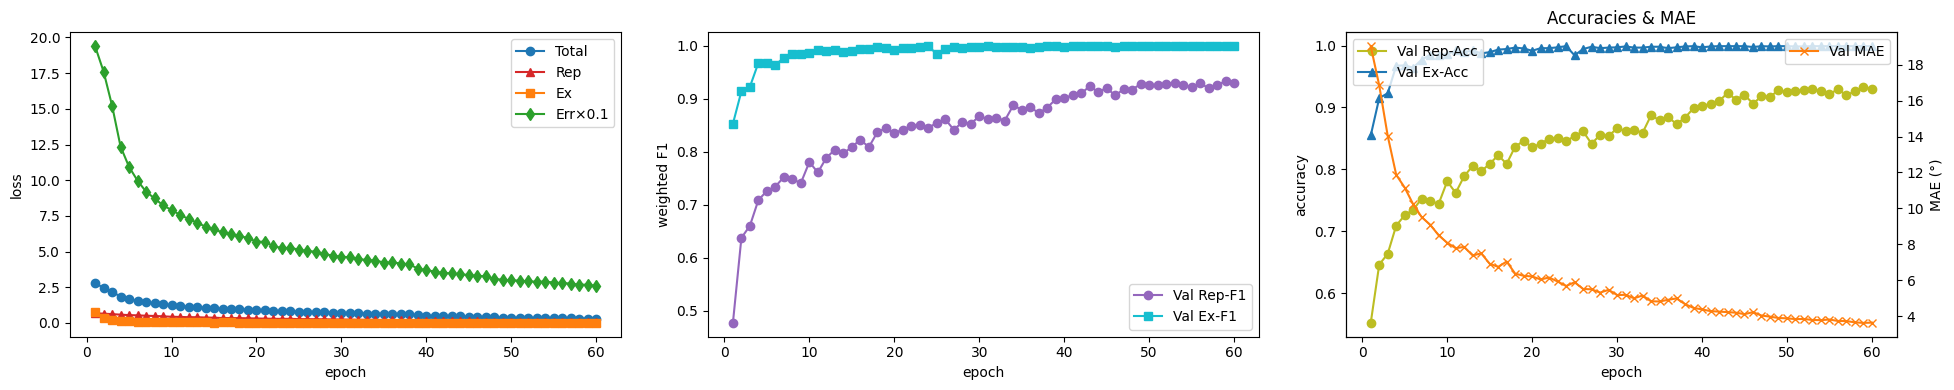

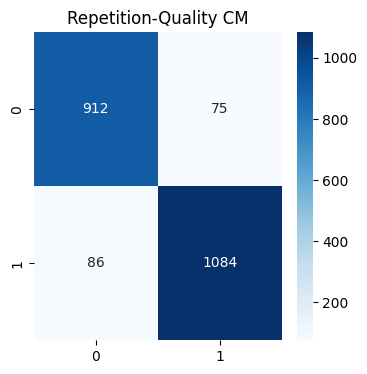

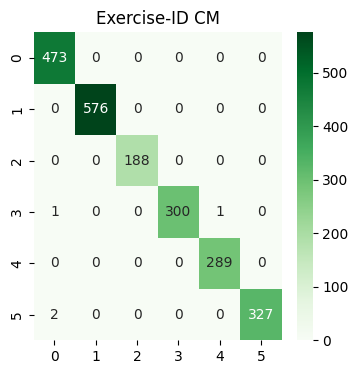

In [25]:
# ╭───────────────────────── CONSTANTS & HELPERS ─────────────────────────╮
PATIENCE         = 6
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)
SAVE_PREFIX = MODEL_DIR / "pose_quality_best"
FPS_DUMMY_FRAMES = 64 #Number of frames used to simulate inference speed (FPS test)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad) / 1e6

@torch.no_grad()
def timed_forward(m, in_dim, t=FPS_DUMMY_FRAMES):
    m.eval()
    dummy_seq = torch.zeros(1, t, in_dim, device=DEVICE)
    dummy_ex  = torch.zeros(1, NUM_EXERCISES, device=DEVICE)
    _ = m(dummy_seq, dummy_ex)             # warm-up
    t0 = time.time(); _ = m(dummy_seq, dummy_ex)
    return t / (time.time() - t0)
# ╰────────────────────────────────────────────────────────────────────────╯


# ─────────────────────────── evaluation helper ──────────────────────────
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    rep_y, rep_p, ex_y, ex_p, err = [], [], [], [], []
    for seq, y, e, ex in loader:
        seq, y, e, ex = [t.to(DEVICE) for t in (seq, y, e, ex)]
        log_rep, ê, log_ex = model(seq, F.one_hot(ex, NUM_EXERCISES).float())
        rep_y += y.cpu().tolist()
        rep_p += log_rep.argmax(1).cpu().tolist()
        ex_y  += ex.cpu().tolist()
        ex_p  += log_ex.argmax(1).cpu().tolist()
        err   += (ê - e).abs().mean(1).cpu().tolist()

    return dict(
        rep_acc = accuracy_score(rep_y, rep_p),
        rep_f1  = f1_score(rep_y, rep_p, average="weighted"),
        ex_acc  = accuracy_score(ex_y, ex_p),
        ex_f1   = f1_score(ex_y, ex_p, average="weighted"),
        mae     = float(np.mean(err)),
        rep_cm  = confusion_matrix(rep_y, rep_p),
        ex_cm   = confusion_matrix(ex_y, ex_p)
    )
# ╰────────────────────────────────────────────────────────────────────────╯


def train(csv_file, keypt_root, *, epochs=60, batch=32, lr=3e-4):
    # ───── prepare data splits ─────────────────────────────────────────────────
    ds  = KeypointWindowDataset(csv_file, keypt_root)
    idx = np.random.permutation(len(ds))
    c1, c2 = int(.7*len(ds)), int(.85*len(ds))
    tr_idx, val_idx, tst_idx = idx[:c1], idx[c1:c2], idx[c2:]

    # class weights + sampler for 'correctness'
    y_tr = [ds.rows[i]["correctness"] for i in tr_idx]
    freq = np.bincount(y_tr)
    cls_w = torch.tensor([1., freq[0]/max(freq[1],1)],
                         dtype=torch.float32, device=DEVICE)
    samp_w = [freq.sum()/(len(freq)*freq[l]) for l in y_tr]

    mk = lambda ids, **kw: DataLoader(Subset(ds, ids), batch_size=batch, **kw)
    tr_dl  = mk(tr_idx, sampler=WeightedRandomSampler(samp_w, len(samp_w)))
    val_dl = mk(val_idx, shuffle=False)
    tst_dl = mk(tst_idx, shuffle=False)
    # ───────────────────────────────────────────────────────────────────────────

    # ───── build model & optimiser ───────────────────────────────────────────────
    in_dim = ds[0][0].shape[-1]
    model  = PoseQualityNetKP(in_dim, NUM_EXERCISES).to(DEVICE)
    print(f"❚ params {count_params(model):.2f} M  •  device {DEVICE}")

    crit_rep = nn.CrossEntropyLoss(weight=cls_w)   # rep-quality
    crit_err = nn.SmoothL1Loss()                   # joint-angle MAE
    crit_ex  = nn.CrossEntropyLoss()               # exercise head
    opt   = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    sched = ReduceLROnPlateau(opt, mode="max", factor=.5, patience=3)
    # ───────────────────────────────────────────────────────────────────────────

    # ───── live dashboard setup ─────────────────────────────────────────────────
    from IPython.display import clear_output
    fig,(axLoss, axF1, axAcc) = plt.subplots(1,3, figsize=(20,4))
    axAcc2 = axAcc.twinx()

    lnTot, = axLoss.plot([], [], "o-", c="tab:blue",   label="Total")
    lnRep, = axLoss.plot([], [], "^-", c="tab:red",    label="Rep")
    lnEx , = axLoss.plot([], [], "s-", c="tab:orange", label="Ex")
    lnErr, = axLoss.plot([], [], "d-", c="tab:green",  label="Err×0.1")

    lnF1rep_v, = axF1.plot([], [], "o-", c="tab:purple", label="Val Rep-F1")
    lnF1ex_v , = axF1.plot([], [], "s-", c="tab:cyan",   label="Val Ex-F1")

    lnAccrep_v, = axAcc.plot([], [], "o-",  c="tab:olive", label="Val Rep-Acc")
    lnAccex_v , = axAcc.plot([], [], "^-",  c="tab:blue",  label="Val Ex-Acc")
    lnMAE_v,    = axAcc2.plot([], [], "x-", c="tab:orange", label="Val MAE")

    for a in (axLoss, axF1, axAcc):
        a.set_xlabel("epoch")
    axLoss.set_ylabel("loss");            axLoss.legend()
    axF1  .set_ylabel("weighted F1");     axF1.legend()
    axAcc .set_ylabel("accuracy");        axAcc2.set_ylabel("MAE (°)")
    axAcc.set_title("Accuracies & MAE")
    axAcc.legend(loc="upper left");      axAcc2.legend(loc="upper right")
    display(fig)
    plt.tight_layout()
    # ───────────────────────────────────────────────────────────────────────────

    # ───── training + early-stopping on validation ──────────────────────────────
    history, best_f1, best_state, stall = [], 0., None, 0
    for ep in range(1, epochs+1):
        # — train epoch —
        model.train()
        totL = repL = exL = errL = 0.0
        for seq,y,e,ex in tr_dl:
            seq,y,e,ex = [t.to(DEVICE) for t in (seq,y,e,ex)]
            opt.zero_grad()
            log_r, ê, log_ex = model(seq, F.one_hot(ex,NUM_EXERCISES).float())
            Lr = crit_rep(log_r,  y)
            Le = crit_err( ê,    e)
            Lx = crit_ex (log_ex,ex)
            loss = Lr + 0.1*Le + 0.2*Lx
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.)
            opt.step()

            bs = y.size(0)
            totL += loss.item()*bs
            repL += Lr.item()*bs
            errL += Le.item()*bs
            exL  += Lx.item()*bs

        # — validation —
        val = evaluate(model, val_dl)
        sched.step(val["rep_f1"])

        history.append({
            "epoch":       ep,
            "train_tot":   totL/len(tr_idx),
            "train_rep":   repL/len(tr_idx),
            "train_err":   errL/len(tr_idx),
            "train_ex":    exL/len(tr_idx),
            "val_rep_f1":  val["rep_f1"],
            "val_ex_f1":   val["ex_f1"],
            "val_rep_acc": val["rep_acc"],
            "val_ex_acc":  val["ex_acc"],
            "val_mae":     val["mae"]
        })

        print(f"E{ep:02d} | train_tot {history[-1]['train_tot']:.3f}  "
              f"Val-Rep-F1 {val['rep_f1']:.3f}  Val-Ex-F1 {val['ex_f1']:.3f}  Val-MAE {val['mae']:.2f}")

        # early-stop on val_rep_f1
        if val["rep_f1"] > best_f1:
            best_f1, best_state, stall = val["rep_f1"], model.state_dict(), 0
            # Save the best mnodel!
            torch.save(best_state, SAVE_PREFIX.with_suffix(".pt"))
            torch.save(model, SAVE_PREFIX.with_suffix(".pth"))
            print(f"✓ New best model saved at epoch {ep}")
        else:
            stall += 1
            if stall >= PATIENCE:
                print("Early stopping.")
                break

        # — update live dashboard —
        xs = [h["epoch"] for h in history]
        lnTot.set_data(xs,[h["train_tot"]   for h in history])
        lnRep.set_data(xs,[h["train_rep"]   for h in history])
        lnErr.set_data(xs,[h["train_err"]   for h in history])
        lnEx .set_data(xs,[h["train_ex"]    for h in history])

        lnF1rep_v.set_data(xs,[h["val_rep_f1"] for h in history])
        lnF1ex_v .set_data(xs,[h["val_ex_f1"]  for h in history])

        lnAccrep_v.set_data(xs,[h["val_rep_acc"] for h in history])
        lnAccex_v .set_data(xs,[h["val_ex_acc"]  for h in history])
        lnMAE_v   .set_data(xs,[h["val_mae"]     for h in history])

        # ← NEW: rescale each axis to fit
        for ax in (axLoss, axF1, axAcc, axAcc2):
            ax.relim()
            ax.autoscale_view()

        clear_output(wait=True)
        display(fig)
    # ───────────────────────────────────────────────────────────────────────────

    # ───── print per-epoch summary table ───────────────────────────────────────
    from tabulate import tabulate
    df = pd.DataFrame(history)
    cols = [
        "epoch",
        "train_tot","train_rep","train_ex","train_err",
        "val_rep_f1","val_ex_f1","val_mae",
        "val_rep_acc","val_ex_acc"
    ]
    print("\n### Per-epoch summary\n")
    print(tabulate(df[cols], headers="keys",
                   floatfmt=".3f", tablefmt="github"))
    # ───────────────────────────────────────────────────────────────────────────

    # ───── final-test evaluation & heatmaps ────────────────────────────────────
    model.load_state_dict(best_state)
    test = evaluate(model, tst_dl)
    print("\n◆ Final test metrics ◆")
    print(f"Rep-Acc: {test['rep_acc']:.3f}, Rep-F1: {test['rep_f1']:.3f}")
    print(f"Ex-Acc:  {test['ex_acc']:.3f}, Ex-F1:  {test['ex_f1']:.3f}")
    print(f"MAE:     {test['mae']:.2f}°")
    print(f"FPS:     {timed_forward(model,in_dim):.1f}")
    print(f"Params:  {count_params(model):.2f} M\n")

    plt.figure(figsize=(4,4))
    sns.heatmap(test["rep_cm"], annot=True, fmt="d", cmap="Blues")
    plt.title("Repetition-Quality CM"); plt.show()

    plt.figure(figsize=(4,4))
    sns.heatmap(test["ex_cm"], annot=True, fmt="d", cmap="Greens")
    plt.title("Exercise-ID CM"); plt.show()

    # dump metrics.json
    pd.DataFrame(history).to_json("metrics.json", indent=2)

# ╭───────────────────────────── RUN ──────────────────────────────╮
train(WIN_CSV, KEYPT_ROOT, epochs=60, batch=32, lr=3e-4)
# ╰────────────────────────────────────────────────────────────────╯



# 7. Ablation study

### Ablation-study score card  – *3-head PoseQualityNet-KP*

We now compare four architectural variants and **seven key metrics per **task**:  
repetition-quality (**Rep**) *and* exercise-ID (**Ex**).

| Metric | Scope | Definition (updated) | Why it matters |
|--------|-------|----------------------|----------------|
| **Rep-accuracy** | Repetition-quality | fraction of windows classified *Correct / Wrong* correctly | First sanity check that the rep-quality head is doing its job |
| **Rep-weighted F1** | Repetition-quality | harmonic mean of precision & recall, weighted by class frequency | Headline score for rep-quality under the 70 : 30 imbalance |
| **Ex-accuracy** | Exercise ID | fraction of windows for which the exercise class (1-6) is predicted correctly | Verifies the network can detect wrong-exercise scenarios at inference time |
| **Ex-weighted F1** | Exercise ID | weighted F1 over the 6-class exercise classifier | More informative than raw accuracy when some exercises are rarer |
| **MAE (°)** | Joint-error head | mean absolute error over the 14 predicted joint-angle deviations | Directly maps to clinical tolerance (±7°); lower = better feedback granularity |
| **Throughput (FPS)** | All heads | forward passes per second on a laptop-GPU / M-series Mac | ≥25 fps needed for real-time coaching |
| **Params (M)** | All heads | millions of trainable parameters | Proxy for memory / mobile compute cost; tells us if a block is “worth” its gains |

---

#### How the table answers the big questions

1. **Does it judge reps *and* exercise type well?**  
   → `Rep-accuracy / F1` **and** `Ex-accuracy / F1`

2. **Is the joint-level feedback useful?**  
   → `MAE (°)` (must stay close to clinical ±7° tolerance)

3. **Can we ship it on-device?**  
   → `FPS` ≥ 25 and `Params (M)` ≲ 4 M  

Blocks that improve (1) and/or (2) **without** breaking (3) survive the ablation.

> After the loop the script prints a styled summary table (one row per variant) and stores per-epoch logs in **`metrics.json`** for deeper dives.


In [26]:
"""
Ablation driver for PoseQualityNetKP (3-head)

Variants  
  A   – CNN only  
  B   – CNN + ex-embedding  
  C   – CNN + Bi-LSTM  
  FULL– CNN + Bi-LSTM + ex-embedding
"""
# PoseQualityNetKP & KeypointWindowDataset must already be in scope
# ---------------------------------------------------------------

SCRIPT_DIR = Path().resolve()
DATA_ROOT  = SCRIPT_DIR / "Data-REHAB24-6_New"
CSV_FILE   = DATA_ROOT / "Segmentation_windows.csv"
KEYPT_ROOT = DATA_ROOT / "mp_keypoints"

DEVICE = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("mps") if torch.backends.mps.is_available()
          else torch.device("cpu"))

NUM_EXERCISES = 6
PATIENCE      = 6
# ╰─────────────────────────────────────────────╯


# ╭──────────── MODEL FACTORY (toggle blocks) ────────────╮
class DummyLSTM(nn.Module):           # keeps interface → (out, h)
    def forward(self, x): return x, None

class Zero64(nn.Module):              # keeps 64-dim embedding
    def forward(self, x):
        return torch.zeros(x.size(0), 64, device=x.device, dtype=x.dtype)

def build_model(variant: str, in_dim: int) -> nn.Module:
    use_lstm = variant in ("C", "FULL")
    use_emb  = variant in ("B", "FULL")

    class Net(PoseQualityNetKP):
        def __init__(self):
            super().__init__(in_dim, NUM_EXERCISES, hidden=256)
            if not use_lstm: self.lstm   = DummyLSTM()
            if not use_emb : self.ex_emb = Zero64()
    return Net().to(DEVICE)
# ╰────────────────────────────────────────────────────────╯


# ╭──────────────────── HELPER FUNCTIONS ────────────────────╮
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    rep_y, rep_p, ex_y, ex_p, err = [], [], [], [], []
    for seq,y,e,ex in loader:
        seq,y,e,ex = [t.to(DEVICE) for t in (seq,y,e,ex)]
        log_rep, ê, log_ex = model(seq, F.one_hot(ex, NUM_EXERCISES).float())
        rep_y += y.cpu().tolist()
        rep_p += log_rep.argmax(1).cpu().tolist()
        ex_y  += ex.cpu().tolist()
        ex_p  += log_ex.argmax(1).cpu().tolist()
        err   += (ê-e).abs().mean(1).cpu().tolist()

    return dict(
        rep_acc = accuracy_score(rep_y, rep_p),
        rep_f1  = f1_score(rep_y, rep_p, average="weighted"),
        ex_acc  = accuracy_score(ex_y , ex_p),
        ex_f1   = f1_score(ex_y , ex_p , average="weighted"),
        mae     = float(np.mean(err)),
        rep_cm  = confusion_matrix(rep_y, rep_p),
        ex_cm   = confusion_matrix(ex_y , ex_p )
    )

def timed_fps(model, in_dim, t=64):
    s = torch.zeros(1,t,in_dim,device=DEVICE)
    e = torch.zeros(1,NUM_EXERCISES,device=DEVICE)
    _ = model(s,e)                                  # warm-up
    if DEVICE.type=="cuda": torch.cuda.synchronize()
    t0 = time.time(); _ = model(s,e)
    if DEVICE.type=="cuda": torch.cuda.synchronize()
    return round(t/(time.time()-t0),1)

def count_params(m):
    return round(sum(p.numel() for p in m.parameters() if p.requires_grad)/1e6,2)
# ╰──────────────────────────────────────────────────────────╯


# ╭────────────────────── ABLATION DRIVER ─────────────────────────╮
def run_ablation(epochs=60, batch=32, lr=3e-4):
    torch.manual_seed(0); np.random.seed(0)

    ds   = KeypointWindowDataset(CSV_FILE, KEYPT_ROOT)
    in_d = ds[0][0].shape[-1]

    idx = np.random.permutation(len(ds)); c1,c2 = int(.7*len(ds)), int(.85*len(ds))
    split = {"train":idx[:c1], "val":idx[c1:c2], "test":idx[c2:]}

    y_tr  = [ds.rows[i]["correctness"] for i in split["train"]]
    freq  = np.bincount(y_tr)
    cls_w = torch.tensor([freq.sum()/(2*freq[0]), freq.sum()/(2*freq[1])],
                         dtype=torch.float32, device=DEVICE)
    samp_w= [freq.sum()/(len(freq)*freq[l]) for l in y_tr]

    mk = lambda ids,**kw: DataLoader(Subset(ds, ids), batch_size=batch, **kw)
    dl = {k: mk(v, sampler=WeightedRandomSampler(samp_w,len(samp_w))
                 if k=="train" else None, shuffle=False)
          for k,v in split.items()}

    rows=[]
    for var in ["A","B","C","FULL"]:
        print(f"\n── Variant {var}")
        model = build_model(var, in_d)
        opt   = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
        best, stall = 0., 0

        for ep in range(1, epochs+1):
            model.train()
            for seq,y,e,ex in dl["train"]:
                seq,y,e,ex=[t.to(DEVICE) for t in (seq,y,e,ex)]
                opt.zero_grad()
                log_r, ê, log_ex = model(seq, F.one_hot(ex,NUM_EXERCISES).float())
                loss = (F.cross_entropy(log_r ,y ,weight=cls_w) +
                        0.1*F.smooth_l1_loss(ê,e) +
                        0.2*F.cross_entropy(log_ex,ex))
                loss.backward(); nn.utils.clip_grad_norm_(model.parameters(),1.)
                opt.step()

            val = evaluate(model, dl["val"])
            if val["rep_f1"]>best: best,stall=val["rep_f1"],0
            else: stall+=1
            if stall>=PATIENCE: break

        test = evaluate(model, dl["test"])
        rows.append(dict(
            variant   = var,
            rep_acc   = test["rep_acc"],   rep_f1 = test["rep_f1"],
            ex_acc    = test["ex_acc"],    ex_f1  = test["ex_f1"],
            mae       = test["mae"],
            fps       = timed_fps(model,in_d),
            params_M  = count_params(model)
        ))
        print(rows[-1])

    df = pd.DataFrame(rows)
    print("\nAblation summary")
    display(df.style.format({"mae":"{:.2f}","params_M":"{:.2f}","fps":"{:.0f}",
                             "rep_acc":"{:.3f}","ex_acc":"{:.3f}",
                             "rep_f1":"{:.3f}","ex_f1":"{:.3f}"}))
# ╰───────────────────────────────────────────────────────────────╯


# ╭────────────────────────── RUN IT ─────────────────────────────╮
run_ablation(epochs=60, batch=32, lr=3e-4)
# ╰───────────────────────────────────────────────────────────────╯


── Variant A
{'variant': 'A', 'rep_acc': 0.7969401947148818, 'rep_f1': 0.7970885932347661, 'ex_acc': 0.9935095039406583, 'ex_f1': 0.9934947647916222, 'mae': 8.49377070199465, 'fps': 8873.9, 'params_M': 0.25}

── Variant B
{'variant': 'B', 'rep_acc': 0.8210477515067223, 'rep_f1': 0.8189087620108026, 'ex_acc': 0.9944367176634215, 'ex_f1': 0.9944256271197209, 'mae': 6.1814127573549165, 'fps': 8643.9, 'params_M': 0.25}

── Variant C
{'variant': 'C', 'rep_acc': 0.8530366249420491, 'rep_f1': 0.8533982943693524, 'ex_acc': 0.9958275382475661, 'ex_f1': 0.9958274053650548, 'mae': 6.116831047312773, 'fps': 7383.5, 'params_M': 3.4}

── Variant FULL
{'variant': 'FULL', 'rep_acc': 0.9031061659712564, 'rep_f1': 0.9030007972037125, 'ex_acc': 0.9972183588317107, 'ex_f1': 0.9972169733899007, 'mae': 3.8554787915174087, 'fps': 7461.1, 'params_M': 3.41}

Ablation summary


,variant,rep_acc,rep_f1,ex_acc,ex_f1,mae,fps,params_M
0,A,0.797,0.797,0.994,0.993,8.49,8874,0.25
1,B,0.821,0.819,0.994,0.994,6.18,8644,0.25
2,C,0.853,0.853,0.996,0.996,6.12,7384,3.40
3,FULL,0.903,0.903,0.997,0.997,3.86,7461,3.41


# 6. Inference Tesing - Correctness and feedback on Live Videos / Recorded Videos 


## 7 Inference & Real-Time Feedback

This notebook cell launches a simple CLI + OpenCV/MediaPipe based inference script that:

1. **Loads** a pretrained `PoseQualityNetKP` checkpoint.  
2. **Initializes** MediaPipe Pose to track 33 landmarks and draws them on each frame.  
3. **Buffers** a sliding window of 16 frames of world‐space keypoints.  
4. **Checks** that all required landmarks for the chosen exercise are visible (visibility ≥ 0.8).  
5. **Runs** the buffer through `PoseQualityNetKP` to obtain:  
   - **`logits_q`** → binary pose‐quality (“Correct” vs “Form issue”)  
   - **`err_hat`**  → 14 joint‐angle deviations in degrees  
   - **`logits_ex`** → predicted exercise ID (for mismatch detection)  
6. **Displays**:
   - A green “You’re on the right track!” if classified correct.  
   - A red “Form issue” plus up to 3 worst joint warnings (e.g. `LEFT_ELBOW +12°`) if incorrect, shown for 90 frames.  
   - Guidance messages (“No pose”, “Adjust posture”, “World landmarks missing”) when detection fails.  
7. **Throttles** live capture to ≈30 FPS (by skipping frames if webcam FPS > 30).  
8. **Cleans up** OpenCV windows and MediaPipe resources on exit.

---

### 🛠️ Key Constants & Parameters

| Name                       | Value            | Purpose                                                         |
|----------------------------|------------------|-----------------------------------------------------------------|
| `VIS_THRESH`               | 0.8              | Minimum landmark visibility to include in error-warning checks. |
| `SEQ_LEN`                  | 16               | Number of frames in the temporal buffer.                        |
| `TH_ERR_DEG`               | 10               | Joint deviation threshold (°) for issuing a warning.            |
| `SUGGESTION_DURATION_FRAMES` | 3×30          | How long (in frames) to display each joint suggestion.          |
| `FPS_DUMMY_FRAMES`         | 64               | Number of dummy frames for FPS measurement at the end.          |

---

### 🚀 How It Works

1. **Video Capture**  
   - Opens either a file path (e.g. `“Videos/Ex1/PM_000-Camera17-30fps.mp4”`) or webcam (`0`).  
   - If webcam, reads `CAP_PROP_FPS` and skips frames to maintain a 30 FPS processing rate.  

2. **MediaPipe Pose**  
   - Detects 33 landmarks each frame; converts to world‐space 3D coordinates.  
   - Draws landmarks with OpenCV on the original BGR frame.  

3. **Buffer & Visibility Check**  
   - Maintains a `collections.deque(maxlen=16)` of flattened `(x,y,z)` world‐space keypoints.  
   - If any required triplet (e.g. `LEFT_SHOULDER–LEFT_ELBOW–LEFT_WRIST`) has visibility < 0.8, resets the buffer and prompts “Adjust posture”.

4. **Model Inference**  
   - Once 16 frames collected:
     - Constructs a `(1,16,99)` tensor (`batch, time, 33 joints×3 coords`).  
     - One‐hot encodes the user‐selected exercise ID (shape `(1,6)`).  
     - Feeds both into `model(seq, ex_1hot)` → `(logits_q, err_hat, logits_ex)`.  

5. **Feedback Logic**  
   - **Exercise mismatch**: if `argmax(logits_ex)+1 ≠ user_ex_id`, displays “Wrong exercise – doing Ex X”.  
   - **Quality classification**:
     - `argmax(logits_q)==1` → “You’re on the right track!” (green).  
     - `argmax(logits_q)==0` → “Form issue” (red), then:
       - Sorts `err_hat` descending by absolute value, picks top 3 joints exceeding `TH_ERR_DEG`.  
       - Formats suggestions (e.g. `“Check LEFT_ELBOW (Dev: +12°)”`) and displays in yellow.  

6. **Overlay & Display**  
   - Uses `cv2.putText` to render exercise name, feedback, and suggestions in color on each frame.  
   - Window title: **“Exercise-coach”**.  
   - Exit on pressing **q**.

---

### ⚙️ How to Run

1. Install dependencies
2. Place files:
    - this script in your working directory
    - Data-REHAB24-6_New/Segmentation_windows.csv & mp_keypoints/
    - model/pose_quality_best.pt checkpoint alongside the script

3. Launch inference
run this cell

4. Input prompts:
Select exercise 1–6:  1  
Video source (0=webcam or path):  0      # for webcam  
or for file:
Video source (0=webcam or full path path):  example: /Users/jithinkrishnan/Documents/Study/IS06 /MVP/RehabApp/model-training-scripts/Data-REHAB24-6_New/videos/Ex1/PM_001-Camera17-30fps.mp4


In [28]:
# ───────────────── Imports ─────────────────
import os
import math
import threading
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
from pathlib import Path
from gtts import gTTS
import mediapipe as mp


SCRIPT_DIR  = Path().resolve()
DATA_ROOT   = SCRIPT_DIR / "model/Data-REHAB24-6_New"
CKPT_PATH   = SCRIPT_DIR / "model/pose_quality_best.pt"      # <─ name from trainer

DEVICE = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("mps") if torch.backends.mps.is_available()
          else torch.device("cpu"))
print("► device =", DEVICE)

# ─── TTS SETUP (FOR VOICE)────────────────────────────────────
def speak(text: str):
    tts = gTTS(text=text, lang='en')
    tts.save("temp.mp3")
    os.system("afplay temp.mp3")  # Use afplay on macOS to play the audio
    os.remove("temp.mp3")

def speak_async(text: str):
    threading.Thread(target=speak, args=(text,), daemon=True).start()

# ╭───────────────────────── CONSTANTS ─────────────────────────╮
mp_pose = mp.solutions.pose
PoseLM  = mp_pose.PoseLandmark
JOINT_NAMES  = [lm.name for lm in PoseLM];   N_JOINTS = len(JOINT_NAMES)

EXERCISE_MAP = {1:"Arm-abduction", 2:"Arm-VW", 3:"Push-ups",
                4:"Leg-abduction", 5:"Lunge", 6:"Squat"}
NUM_EX = len(EXERCISE_MAP)

# joints whose angle MAE the model predicts (same order as training)
ERR_JOINTS = [
    "LEFT_ELBOW","RIGHT_ELBOW","LEFT_SHOULDER","RIGHT_SHOULDER",
    "LEFT_HIP","RIGHT_HIP","LEFT_KNEE","RIGHT_KNEE",
    "SPINE","HEAD","LEFT_WRIST","RIGHT_WRIST","LEFT_ANKLE","RIGHT_ANKLE"
];   N_ERR = len(ERR_JOINTS)

JOINT_LABELS = [j.replace('_', ' ').lower() for j in ERR_JOINTS] # → ["left elbow", "right elbow", ..., "right ankle"]

# index triplets for live angle warnings (unchanged)
JOINT_TRIPLETS = {
    "LEFT_ELBOW": (PoseLM.LEFT_SHOULDER, PoseLM.LEFT_ELBOW, PoseLM.LEFT_WRIST),
    "RIGHT_ELBOW":(PoseLM.RIGHT_SHOULDER,PoseLM.RIGHT_ELBOW,PoseLM.RIGHT_WRIST),
    "LEFT_SHOULDER": (PoseLM.LEFT_ELBOW, PoseLM.LEFT_SHOULDER, PoseLM.LEFT_HIP),
    "RIGHT_SHOULDER":(PoseLM.RIGHT_ELBOW,PoseLM.RIGHT_SHOULDER,PoseLM.RIGHT_HIP),
    "LEFT_HIP": (PoseLM.LEFT_SHOULDER,PoseLM.LEFT_HIP,PoseLM.LEFT_KNEE),
    "RIGHT_HIP":(PoseLM.RIGHT_SHOULDER,PoseLM.RIGHT_HIP,PoseLM.RIGHT_KNEE),
    "LEFT_KNEE": (PoseLM.LEFT_HIP,PoseLM.LEFT_KNEE,PoseLM.LEFT_ANKLE),
    "RIGHT_KNEE":(PoseLM.RIGHT_HIP,PoseLM.RIGHT_KNEE,PoseLM.RIGHT_ANKLE),
    "SPINE": (PoseLM.LEFT_HIP,PoseLM.LEFT_SHOULDER,PoseLM.RIGHT_SHOULDER),
    "HEAD":  (PoseLM.LEFT_SHOULDER,PoseLM.NOSE,PoseLM.RIGHT_SHOULDER),
    "LEFT_WRIST": (PoseLM.LEFT_ELBOW,PoseLM.LEFT_WRIST,PoseLM.LEFT_INDEX),
    "RIGHT_WRIST":(PoseLM.RIGHT_ELBOW,PoseLM.RIGHT_WRIST,PoseLM.RIGHT_INDEX),
    "LEFT_ANKLE": (PoseLM.LEFT_KNEE,PoseLM.LEFT_ANKLE,PoseLM.LEFT_FOOT_INDEX),
    "RIGHT_ANKLE":(PoseLM.RIGHT_KNEE,PoseLM.RIGHT_ANKLE,PoseLM.RIGHT_FOOT_INDEX)
}

VIS_THRESH  = 0.8
SEQ_LEN     = 16
IN_DIM      = N_JOINTS * 3
TH_ERR_DEG  = 10      # show joint warning if |err| ≥ 10°

# ╭─────────────────────── MODEL DEFINITION ───────────────────────╮
# ────────────────── Feature encoder (unchanged) ──────────────────
class KeypointEncoder(nn.Module):
    def __init__(self, in_dim: int, embed: int = 512):
        super().__init__()
        self.conv1 = nn.Conv1d(in_dim, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, embed, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):                                # x: (B, D)
        x = torch.relu(self.conv1(x.unsqueeze(2)))
        x = torch.relu(self.conv2(x))
        return self.pool(x).squeeze(-1)                  # (B, embed = 512)

# ───────────────── Pose-Quality–Exercise network ─────────────────
class PoseQualityNetKP(nn.Module):
    """
    Outputs:
        logits_q  : (B, 2)   – Correct / Wrong
        err_hat   : (B, N_ERR) – joint-angle errors
        logits_ex : (B, num_ex) – predicted exercise ID
    """
    def __init__(self, in_dim: int,
                 num_ex: int,
                 hidden: int = 256,
                 ex_emb: int = 64):
        super().__init__()
        # 1) per-frame feature extractor
        self.encoder = KeypointEncoder(in_dim)           # → 512-d frame vec
        # 2) sequence model
        self.lstm = nn.LSTM(
            512, hidden, num_layers=2,
            batch_first=True, bidirectional=True
        )
        feat_dim = hidden * 2                            # 256×2 = 512
        # 3) exercise embedding ( fed with *user-selected* one-hot )
        self.ex_emb = nn.Sequential(
            nn.Linear(num_ex, ex_emb), nn.ReLU(),
            nn.Linear(ex_emb, ex_emb)
        )
        # 4) heads
        self.cls_head = nn.Linear(feat_dim + ex_emb, 2)      # quality
        self.err_head = nn.Linear(feat_dim + ex_emb, N_ERR)  # MAE
        self.ex_head  = nn.Linear(feat_dim,          num_ex) # exercise ✔︎

    def forward(self,
                seq: torch.Tensor,      # (B, T, D)
                ex_1hot: torch.Tensor   # (B, num_ex)  user-selected
    ):
        B, T, _ = seq.shape

        # frame-wise encoding
        feats = torch.stack(
            [self.encoder(seq[:, t]) for t in range(T)], dim=1
        )                                               # (B, T, 512)
        out, _ = self.lstm(feats)                       # (B, T, 512)
        g = out.mean(1)                                 # (B, 512)
        # exercise embedding (context for quality / error heads only)
        ex_e = self.ex_emb(ex_1hot)                     # (B, 64)
        h = torch.cat([g, ex_e], dim=1)                 # (B, 576)
        logits_q  = self.cls_head(h)                    # (B, 2)
        err_hat   = self.err_head(h)                    # (B, N_ERR)
        logits_ex = self.ex_head(g)                     # (B, num_ex) ← uses g

        return logits_q, err_hat, logits_ex

# ╰─────────────────────────────────────────────────────────────────╯


# ╭───────────────────── LOAD TRAINED MODEL ───────────────────────╮
if not CKPT_PATH.exists():
    raise FileNotFoundError(f"{CKPT_PATH} not found")
print("Loading model …")
model=torch.load(CKPT_PATH,map_location=DEVICE)
if isinstance(model,dict):        # state_dict case
    m=PoseQualityNetKP(IN_DIM,NUM_EX).to(DEVICE)
    m.load_state_dict(model); model=m
model.eval();  print("✓ model ready")

# ╭─────────────── MEDIAPIPE INITIALISATION ───────────────────────╮
pose = mp_pose.Pose(False,2,False,
                    min_detection_confidence=0.8,
                    min_tracking_confidence=0.8)
drawer= mp.solutions.drawing_utils

# ╭─────────────────────── HELPERS ────────────────────────────────╮
def euler_angle(p1,p2,p3):
    a,b,c=np.array(p1),np.array(p2),np.array(p3)
    v1=a-b; v2=c-b
    ang= math.degrees(math.acos(
        np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)+1e-8)))
    return ang

def world_kps_from_result(res):
    return np.array([(lm.x,lm.y,lm.z) for lm in res.pose_world_landmarks.landmark],
                    np.float32)

def required_visible(res, ex_id):
    req = set(JOINT_TRIPLETS.keys()) if ex_id!=3 else {"RIGHT_ELBOW","RIGHT_SHOULDER","SPINE"}
    idx=set(); [idx.update(JOINT_TRIPLETS[j]) for j in req]
    return all(res.pose_landmarks.landmark[i.value].visibility>=VIS_THRESH for i in idx)

# ╭────────────────── CORE INFERENCE LOOP ─────────────────────────╮
def run_live(video_src, user_ex_id):
    last_message = ""
    user_ex_name = EXERCISE_MAP[user_ex_id]
    cap = cv2.VideoCapture(video_src)
    if video_src==0:                       # webcam – resample to 30 fps
        src_fps=cap.get(cv2.CAP_PROP_FPS) or 30
        skip=max(1,round(src_fps/30))
    else: skip=1
    buf=deque(maxlen=SEQ_LEN)
    feedback    = "Initialising…"
    suggestion  = ""
    warn_ctr    = 0

    while cap.isOpened():
        ok, frame = cap.read()
        if not ok:                      # end-of-stream
            break
        if video_src==0 and cap.get(cv2.CAP_PROP_POS_FRAMES)%skip: continue
        rgb=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        res=pose.process(rgb)
        if res.pose_landmarks:   drawer.draw_landmarks(
                frame, res.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # ---------- state machine ----------
        if not res.pose_landmarks:
            feedback="No pose detected"; buf.clear(); suggestion=""
        elif not required_visible(res,user_ex_id):
            feedback="Adjust your posture"; buf.clear(); suggestion=""
        elif not res.pose_world_landmarks:
            feedback="World landmarks missing"; buf.clear(); suggestion=""
        else:
            buf.append(world_kps_from_result(res).flatten())
            if len(buf)==SEQ_LEN:
                seq=torch.tensor(np.array(buf),dtype=torch.float32,
                                 device=DEVICE).unsqueeze(0)
                ex_1h=F.one_hot(torch.tensor([user_ex_id-1],device=DEVICE),
                                NUM_EX).float()
                with torch.no_grad():
                    log_q, err_hat, log_ex = model(seq, ex_1h)
                q_pred = log_q.argmax(1).item()       # 0 / 1
                ex_pred= log_ex.argmax(1).item()+1     # 1…6
                errs   = err_hat.squeeze().cpu().numpy()

                # mismatch branch ------------------------------------------------
                if ex_pred != user_ex_id:
                    pred_name = EXERCISE_MAP.get(ex_pred, f"Ex {ex_pred}")
                    feedback = f"Wrong exercise! It looks like you're doing {pred_name}."
                    suggestion="";  warn_ctr=0
                else:
                    if q_pred==1:
                        feedback="You're on the right track!"
                        suggestion=""; warn_ctr=0
                    else:
                        feedback = "You're doing it wrongly!"
                        bad_idxs = np.argsort(np.abs(errs))[::-1][:3]
                        # pick joints above threshold
                        joints = [
                            JOINT_LABELS[i]
                            for i in bad_idxs
                            if abs(errs[i]) >= TH_ERR_DEG
                        ]

                        if joints:
                            # build “a, b and c” style list
                            if len(joints) == 1:
                                joint_str = joints[0]
                            elif len(joints) == 2:
                                joint_str = f"{joints[0]} and {joints[1]}"
                            else:
                                joint_str = f"{joints[0]}, {joints[1]} and {joints[2]}"
                            suggestion = f"Please adjust your {joint_str} properly."
                        else:
                            suggestion = "Check your form."
                        warn_ctr = 30                    # show for ~1 s
            else:
                feedback=f"Analysing {len(buf)}/{SEQ_LEN}"
                suggestion=""

        # ─ speak any change ───────────────────────────────────────
        message = (
            feedback if not suggestion
            else f"{feedback}. {suggestion}"
        )
        if message != last_message:
            speak_async(message)
            last_message = message
            
        # ---------------- draw text ----------------------------------
        cv2.putText(frame,f"Exercise {user_ex_id}: {user_ex_name}",(15,40),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)

        color={"No pose detected":(0,0,255),"Adjust your posture":(0,165,255),
               "World landmarks missing":(0,0,255)}.get(feedback,(0,255,0) if
               "You're on the right track!" in feedback else (0,0,255))

        cv2.putText(frame,feedback,(15,90),cv2.FONT_HERSHEY_SIMPLEX,1.2,
                    color,3,cv2.LINE_AA)

        if warn_ctr>0 and suggestion:
            cv2.putText(frame,suggestion,(15,140),cv2.FONT_HERSHEY_SIMPLEX,0.9,
                        (0,255,255),2,cv2.LINE_AA); warn_ctr-=1

        cv2.imshow("Exercise-coach",frame)
        if cv2.waitKey(1)&0xFF==ord('q'): break

    cap.release(); cv2.destroyAllWindows(); pose.close()
# ╰───────────────────────────────────────────────────────────────╯


# ╭────────────────────── USER PROMPTS & RUN ──────────────────────╮
while True:
    try:
        ex_id=int(input(f"Select exercise 1-{NUM_EX}: "))
        if 1<=ex_id<=NUM_EX: break
    except: pass
print("(0 = webcam, or drop a video path)"); src=input("Video source (0 = webcam, or drop a video path): ")
src=0 if src.strip()=="0" else src.strip()
if src and src!="0" and not Path(src).exists():
    print("File not found"); raise SystemExit
run_live(src,ex_id)
# ╰───────────────────────────────────────────────────────────────╯


/var/folders/pv/99z70cjs7t1dx16_0r1c33hw0000gn/T/ipykernel_27593/3923950032.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(CKPT_PATH,map_location=DEV

► device = mps
Loading model …
✓ model ready


W0000 00:00:1745637022.139579  971468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745637022.164892  971476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(0 = webcam, or drop a video path)


2025-04-26 11:11:02.747 python[27593:944089] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-26 11:11:02.748 python[27593:944089] +[IMKInputSession subclass]: chose IMKInputSession_Modern
W0000 00:00:1745637064.419494  971478 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Error: AudioFileOpen failed ('wht?')
Exception in thread Thread-6 (speak):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/pv/99z70cjs7t1dx16_0r1c33hw0000gn/T/ipykernel_2

Error: AudioFileOpen failed ('wht?')
Exception in thread Thread-106 (speak):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/pv/99z70cjs7t1dx16_0r1c33hw0000gn/T/ipykernel_27593/3923950032.py", line 30, in speak
FileNotFoundError: [Errno 2] No such file or directory: 'temp.mp3'
Error: AudioFileOpen failed ('wht?')
Exception in thread Thread-107 (speak):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/envs/rehabtrainingpy312/lib/python3